In [1]:
%load_ext autoreload
%autoreload 2
import sys
import math
import torch
from torch.nn import Module
from tqdm import tqdm
from torch import nn
from typing import *
from torch.nn import functional as F
from torch import LongTensor as LT
import numpy as np
from torch import FloatTensor as FT
from torch import Tensor as T
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import sys
from pathlib import Path
from data_masker import get_maksed_tokens
sys.path.append('./..')

from PanjivaDataPreprocessor import data_fetcher_v1
from torch.utils.data import DataLoader

from decoder_MLM_v1 import decoder_MLM_layer

from encoder_v1 import Encoder 
from data_masker import get_maksed_tokens

class MLM_DataSet(torch.utils.data.Dataset):
    def __init__(self, data, cardinality):
        super(MLM_DataSet).__init__()
        
        data, labels, token_weights = get_maksed_tokens(
            data, 
            cardinality
        )
        self.data = data
        self.labels = labels
        self.token_weights = np.array(token_weights, dtype=float)
        return 
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        record = self.data[idx]
        label = self.labels[idx]
        token_weight = self.token_weights[idx]
        return record, label, token_weight
    

class tabXformerMLM_obj:
    def __init__(
        self,
        emb_dim:int,
        encoder_xformer_heads:int,
        count_numerical_attr:int,
        cardinality: List,
        encoder_num_xformer_layers:int,
        encoder_include_PE: bool,
        decoder_ffn_layer_dims: List,
        model_save_dir,
        device
    ):
        
        self.device = device
        self.encoder_obj = Encoder(
            emb_dim = emb_dim,
            xformer_heads = encoder_xformer_heads,
            xformer_model_dims =  encoder_xformer_heads * emb_dim,
            cardinality = cardinality,
            count_numerical_attr=0,
            device = device,
            num_xformer_layers = encoder_num_xformer_layers,
            include_PE = encoder_include_PE
        )
        self.model_save_dir = model_save_dir 
        
        self.encoder_obj.to(self.device)
        self.decoder_obj = decoder_MLM_layer(
            emb_dim = emb_dim,
            ffn_layer_dims = decoder_ffn_layer_dims,
            attribute_cardinality=cardinality,
            device = device
        )
        self.decoder_obj.to(self.device)
        self.cardinality = cardinality
        self.CE_loss = nn.ModuleList([ nn.CrossEntropyLoss() for _ in cardinality ])
        
        self.optimizer = torch.optim.Adam(
            [
                {'params': self.encoder_obj.parameters(), 'lr': 5e-4},
                {'params': self.decoder_obj.parameters(), 'lr': 5e-4}
            ]
        )
        return 
    
    def save_model(self):
        Path(self.model_save_dir).mkdir( exist_ok=True, parents=True)
        fpath = os.path.join(self.model_save_dir, 'encoder_mlm.pth')
        torch.save(self.encoder_obj, fpath)
        fpath = os.path.join(self.model_save_dir, 'decoder_mlm.pth')
        torch.save(self.decoder_obj, fpath)
        
    # ======
    # MLM loss function
    # ======
    def mlm_loss(
        self,
        enc_seq_data,
        token_pred,
        labels,
        token_weights
    ):

        seq_len = enc_seq_data.shape[1]
        
        # Calculate croiss entropy loss
        # preds = torch.split(token_pred, split_size_or_sections = seq_len, dim=0)
        preds = token_pred
        labels_split = torch.chunk(labels, seq_len,  dim =-1)
        token_weights = torch.chunk(token_weights, seq_len,  dim =-1) 
        
        losses = []
        loss = 0
        
        for i in range(seq_len):
            one_hot = F.one_hot(labels_split[i].squeeze(-1), num_classes = cardinality[i])
            ce = (one_hot * torch.log( preds[i] + 1e-7))[one_hot.bool()]
            ce = -1  * token_weights[i].squeeze(-1) * ce
            _loss = ce

            loss += torch.mean(_loss, dim =-1, keepdims=False)
            losses.append(torch.mean(_loss, dim =-1, keepdims=False))
            
        return losses,loss


    def train_model(
        self, 
        data,
        batch_size = 32,
        num_epochs=10
    ):
        # Create dataset obj
        data_set_obj = MLM_DataSet(
            data, 
            cardinality 
        )
        
        data_loader = DataLoader(data_set_obj, batch_size=batch_size, shuffle=True)
        epoch_losses = []
        all_losses = []
        for epoch in tqdm(range(num_epochs)):
            cur_epoch_losses = []
            print('[Epoch]', epoch)
            for batch_idx, batch_data in enumerate(data_loader):
                
                self.optimizer.zero_grad()
                seq_data, labels, token_wt  = batch_data[0], batch_data[1], batch_data[2] 
                seq_data = LT(seq_data).to(self.device)
                labels = LT(labels).to(self.device)
                token_wt = torch.tensor(token_wt).float().to(self.device)
                enc_seq_data, _ = self.encoder_obj(seq_data)
                token_pred = self.decoder_obj(enc_seq_data)

                losses, batch_loss = self.mlm_loss(
                    enc_seq_data,
                    token_pred,
                    labels,
                    token_wt
                )
                batch_loss.backward()
                self.optimizer.step()
                if (batch_idx+1)%50 == 0:
                    print('Batch ',batch_idx, batch_loss.cpu().data.numpy())
                loss_val = batch_loss.cpu().data.numpy()
                
                cur_epoch_losses.append(loss_val)
                all_losses.append(loss_val)
               
            epoch_losses.append(np.mean(cur_epoch_losses))
            print('[Mean epoch loss] {:4f}'.format(epoch_losses[-1]))
            
        return all_losses
    

In [2]:
record_data = data_fetcher_v1.get_training_set_data('us_import1')
del record_data['PanjivaRecordID']
# data = record_data.head(5000)
data = record_data
data = data.values + 1
domain_dims_df = data_fetcher_v1.get_domain_dims('us_import1')
cardinality = domain_dims_df['dimension'].tolist()
cardinality = [ _ + 1 for _ in cardinality]

In [3]:
xformer_obj = tabXformerMLM_obj(
        emb_dim = 32,
        encoder_xformer_heads = 8,
        count_numerical_attr = 0 ,
        cardinality = cardinality,
        encoder_num_xformer_layers = 3,
        encoder_include_PE = True,
        decoder_ffn_layer_dims = [128,64],
        device = DEVICE,
        model_save_dir = 'model_save_dir'
)

In [4]:
losses = xformer_obj.train_model(data, batch_size = 256, num_epochs = 200)

column_indices.shape (123839, 8)


  0%|                                                                                                                                                                                                                                                 | 0/200 [00:00<?, ?it/s]

[Epoch] 0


/tmp/ipykernel_9824/3356079846.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_wt = torch.tensor(token_wt).float().to(self.device)


Batch  49 5.2351475
Batch  99 4.8839684
Batch  149 4.6083493
Batch  199 4.54779
Batch  249 4.1850166
Batch  299 4.3283296
Batch  349 4.2336197
Batch  399 4.481608
Batch  449 4.0439367


  0%|█▏                                                                                                                                                                                                                                       | 1/200 [00:18<59:42, 18.00s/it]

[Mean epoch loss] 4.592493
[Epoch] 1
Batch  49 3.9289432
Batch  99 4.032133
Batch  149 4.3025684
Batch  199 3.899413
Batch  249 3.8158298
Batch  299 4.021037
Batch  349 3.871513
Batch  399 3.8091433
Batch  449 3.9745913


  1%|██▎                                                                                                                                                                                                                                      | 2/200 [00:36<59:24, 18.00s/it]

[Mean epoch loss] 3.791209
[Epoch] 2
Batch  49 3.6428332
Batch  99 3.5805209
Batch  149 3.3378057
Batch  199 3.4783423
Batch  249 3.3407779
Batch  299 3.5887108
Batch  349 3.4985185
Batch  399 3.3386502
Batch  449 3.1395922


  2%|███▍                                                                                                                                                                                                                                   | 3/200 [00:54<1:00:00, 18.27s/it]

[Mean epoch loss] 3.461514
[Epoch] 3
Batch  49 3.4068475
Batch  99 2.88569
Batch  149 3.196485
Batch  199 3.5450797
Batch  249 3.3263335
Batch  299 3.3652222
Batch  349 2.959701
Batch  399 3.4800947
Batch  449 3.5735652


  2%|████▋                                                                                                                                                                                                                                    | 4/200 [01:13<59:51, 18.33s/it]

[Mean epoch loss] 3.258891
[Epoch] 4
Batch  49 2.9420767
Batch  99 3.1601696
Batch  149 3.3932223
Batch  199 3.0761254
Batch  249 2.9891932
Batch  299 2.8653598
Batch  349 3.1094475
Batch  399 2.8194532
Batch  449 2.984024


  2%|█████▊                                                                                                                                                                                                                                   | 5/200 [01:31<59:44, 18.38s/it]

[Mean epoch loss] 3.115830
[Epoch] 5
Batch  49 3.015693
Batch  99 2.9172165
Batch  149 2.8544757
Batch  199 3.0370774
Batch  249 3.0221033
Batch  299 2.8915148
Batch  349 3.139173
Batch  399 2.8743017
Batch  449 2.9376364


  3%|██████▉                                                                                                                                                                                                                                  | 6/200 [01:49<59:31, 18.41s/it]

[Mean epoch loss] 3.005258
[Epoch] 6
Batch  49 3.0283465
Batch  99 2.4925275
Batch  149 2.9033551
Batch  199 2.7525287
Batch  249 3.035095
Batch  299 2.8325632
Batch  349 2.8868773
Batch  399 2.7388253
Batch  449 3.0216565


  4%|████████▏                                                                                                                                                                                                                                | 7/200 [02:08<59:23, 18.46s/it]

[Mean epoch loss] 2.910605
[Epoch] 7
Batch  49 3.011601
Batch  99 2.4596803
Batch  149 3.1410668
Batch  199 2.614724
Batch  249 2.8794544
Batch  299 2.9946954
Batch  349 3.0430174
Batch  399 2.8625474
Batch  449 3.0501559


  4%|█████████▎                                                                                                                                                                                                                               | 8/200 [02:27<59:19, 18.54s/it]

[Mean epoch loss] 2.832531
[Epoch] 8
Batch  49 2.6923192
Batch  99 2.7592597
Batch  149 2.783766
Batch  199 2.646276
Batch  249 2.492857
Batch  299 3.2868824
Batch  349 2.9220672
Batch  399 2.3732145
Batch  449 2.894465


  4%|██████████▍                                                                                                                                                                                                                              | 9/200 [02:45<58:42, 18.44s/it]

[Mean epoch loss] 2.764658
[Epoch] 9
Batch  49 2.629366
Batch  99 2.6064153
Batch  149 2.54446
Batch  199 2.54892
Batch  249 2.563397
Batch  299 2.7652662
Batch  349 2.909329
Batch  399 2.9479065
Batch  449 2.7337294


  5%|███████████▌                                                                                                                                                                                                                            | 10/200 [03:04<59:05, 18.66s/it]

[Mean epoch loss] 2.703416
[Epoch] 10
Batch  49 2.645737
Batch  99 2.8581147
Batch  149 2.4696267
Batch  199 3.0195832
Batch  249 3.1622188
Batch  299 2.4605975
Batch  349 2.5735602
Batch  399 2.6934953
Batch  449 2.7686114


  6%|████████████▊                                                                                                                                                                                                                           | 11/200 [03:22<58:19, 18.51s/it]

[Mean epoch loss] 2.644748
[Epoch] 11
Batch  49 2.7412283
Batch  99 2.7633593
Batch  149 2.4761329
Batch  199 2.4343011
Batch  249 2.4791336
Batch  299 2.6906586
Batch  349 2.5015392
Batch  399 2.3884926
Batch  449 2.766397


  6%|█████████████▊                                                                                                                                                                                                                        | 12/200 [03:44<1:00:50, 19.42s/it]

[Mean epoch loss] 2.594129
[Epoch] 12
Batch  49 2.630439
Batch  99 2.290179
Batch  149 2.5040112
Batch  199 2.611349
Batch  249 2.5637176
Batch  299 2.328428
Batch  349 2.8231163
Batch  399 2.3306124
Batch  449 2.527938


  6%|██████████████▉                                                                                                                                                                                                                       | 13/200 [04:03<1:00:28, 19.40s/it]

[Mean epoch loss] 2.545743
[Epoch] 13
Batch  49 2.315561
Batch  99 2.794035
Batch  149 2.659222
Batch  199 2.3373642
Batch  249 2.4964325
Batch  299 2.195702
Batch  349 2.844152
Batch  399 2.2477715
Batch  449 2.5586195


  7%|████████████████▏                                                                                                                                                                                                                       | 14/200 [04:22<59:43, 19.27s/it]

[Mean epoch loss] 2.508056
[Epoch] 14
Batch  49 2.1288188
Batch  99 2.4452243
Batch  149 2.4223049
Batch  199 2.2218523
Batch  249 2.3499305
Batch  299 2.5973394
Batch  349 2.3680634
Batch  399 2.4321415
Batch  449 2.3797538


  8%|█████████████████▍                                                                                                                                                                                                                      | 15/200 [04:42<59:52, 19.42s/it]

[Mean epoch loss] 2.468993
[Epoch] 15
Batch  49 2.3791435
Batch  99 2.356022
Batch  149 2.6403284
Batch  199 2.7506838
Batch  249 2.6703954
Batch  299 2.7351646
Batch  349 2.726828
Batch  399 2.453549
Batch  449 2.3976798


  8%|██████████████████▌                                                                                                                                                                                                                     | 16/200 [05:00<58:45, 19.16s/it]

[Mean epoch loss] 2.433514
[Epoch] 16
Batch  49 2.3427393
Batch  99 2.4500456
Batch  149 2.5592403
Batch  199 2.2658067
Batch  249 2.7694147
Batch  299 2.2426775
Batch  349 2.4903953
Batch  399 2.5898402
Batch  449 2.5154064


  8%|███████████████████▋                                                                                                                                                                                                                    | 17/200 [05:20<58:23, 19.14s/it]

[Mean epoch loss] 2.402736
[Epoch] 17
Batch  49 2.0793762
Batch  99 2.4812012
Batch  149 2.3452032
Batch  199 2.428604
Batch  249 2.368665
Batch  299 2.2111123
Batch  349 2.2782316
Batch  399 2.0379536
Batch  449 2.1727724


  9%|████████████████████▉                                                                                                                                                                                                                   | 18/200 [05:39<58:07, 19.16s/it]

[Mean epoch loss] 2.363369
[Epoch] 18
Batch  49 2.219609
Batch  99 2.275203
Batch  149 2.3805895
Batch  199 2.3130534
Batch  249 2.2453349
Batch  299 2.3201854
Batch  349 2.1462507
Batch  399 2.5014062
Batch  449 2.1222138


 10%|██████████████████████                                                                                                                                                                                                                  | 19/200 [05:56<56:30, 18.73s/it]

[Mean epoch loss] 2.342478
[Epoch] 19
Batch  49 2.6571698
Batch  99 2.1522284
Batch  149 2.020953
Batch  199 2.378928
Batch  249 2.1768086
Batch  299 2.388864
Batch  349 2.0364642
Batch  399 2.2140825
Batch  449 2.2065814


 10%|███████████████████████▏                                                                                                                                                                                                                | 20/200 [06:15<56:26, 18.81s/it]

[Mean epoch loss] 2.311534
[Epoch] 20
Batch  49 2.1508687
Batch  99 2.3537562
Batch  149 1.945672
Batch  199 2.456022
Batch  249 2.7065427
Batch  299 2.0171638
Batch  349 2.289871
Batch  399 2.0905733
Batch  449 2.4444804


 10%|████████████████████████▎                                                                                                                                                                                                               | 21/200 [06:35<56:37, 18.98s/it]

[Mean epoch loss] 2.288939
[Epoch] 21
Batch  49 2.044045
Batch  99 2.1151776
Batch  149 2.3127322
Batch  199 2.2502801
Batch  249 1.9155811
Batch  299 2.4107337
Batch  349 1.8997818
Batch  399 2.6505914
Batch  449 2.3331528


 11%|█████████████████████████▌                                                                                                                                                                                                              | 22/200 [06:54<56:46, 19.14s/it]

[Mean epoch loss] 2.262482
[Epoch] 22
Batch  49 2.1883938
Batch  99 2.3934474
Batch  149 2.1978934
Batch  199 2.354135
Batch  249 2.1787941
Batch  299 2.2142434
Batch  349 2.1260269
Batch  399 2.0700934
Batch  449 1.9422622


 12%|██████████████████████████▋                                                                                                                                                                                                             | 23/200 [07:14<56:54, 19.29s/it]

[Mean epoch loss] 2.237484
[Epoch] 23
Batch  49 2.2586398
Batch  99 2.0349438
Batch  149 1.999601
Batch  199 1.9327633
Batch  249 2.2542367
Batch  299 2.235845
Batch  349 1.9346766
Batch  399 2.3070517
Batch  449 2.318549


 12%|███████████████████████████▊                                                                                                                                                                                                            | 24/200 [07:33<56:27, 19.25s/it]

[Mean epoch loss] 2.216852
[Epoch] 24
Batch  49 1.9771769
Batch  99 1.9965339
Batch  149 2.2979877
Batch  199 2.5367508
Batch  249 2.0565147
Batch  299 2.303198
Batch  349 2.0825214
Batch  399 2.3541973
Batch  449 2.314105


 12%|█████████████████████████████                                                                                                                                                                                                           | 25/200 [07:53<56:15, 19.29s/it]

[Mean epoch loss] 2.195028
[Epoch] 25
Batch  49 2.0356834
Batch  99 2.1332004
Batch  149 2.112967
Batch  199 2.3052552
Batch  249 1.888811
Batch  299 2.169761
Batch  349 2.104686
Batch  399 2.2379582
Batch  449 2.5953524


 13%|██████████████████████████████▏                                                                                                                                                                                                         | 26/200 [08:14<57:41, 19.89s/it]

[Mean epoch loss] 2.175464
[Epoch] 26
Batch  49 2.259265
Batch  99 2.009225
Batch  149 2.2052393
Batch  199 2.0064864
Batch  249 2.2810023
Batch  299 2.178085
Batch  349 1.88855
Batch  399 2.4898217
Batch  449 2.3206527


 14%|███████████████████████████████▎                                                                                                                                                                                                        | 27/200 [08:34<58:01, 20.13s/it]

[Mean epoch loss] 2.158956
[Epoch] 27
Batch  49 1.9482515
Batch  99 2.2267296
Batch  149 1.9928702
Batch  199 2.1367865
Batch  249 2.0844586
Batch  299 2.2333012
Batch  349 1.9565287
Batch  399 2.2117336
Batch  449 2.3271947


 14%|████████████████████████████████▍                                                                                                                                                                                                       | 28/200 [08:54<56:45, 19.80s/it]

[Mean epoch loss] 2.138346
[Epoch] 28
Batch  49 1.9370776
Batch  99 2.091247
Batch  149 2.0639381
Batch  199 2.0771017
Batch  249 2.0394096
Batch  299 2.5712044
Batch  349 2.2380521
Batch  399 2.2141135
Batch  449 2.0220804


 14%|█████████████████████████████████▋                                                                                                                                                                                                      | 29/200 [09:14<56:52, 19.96s/it]

[Mean epoch loss] 2.124521
[Epoch] 29
Batch  49 1.8007419
Batch  99 2.055413
Batch  149 1.735581
Batch  199 2.091332
Batch  249 2.051742
Batch  299 2.5416818
Batch  349 1.8473778
Batch  399 2.3611853
Batch  449 2.230463


 15%|██████████████████████████████████▊                                                                                                                                                                                                     | 30/200 [09:33<55:35, 19.62s/it]

[Mean epoch loss] 2.106866
[Epoch] 30
Batch  49 2.0960152
Batch  99 1.9481498
Batch  149 1.7623699
Batch  199 1.6644137
Batch  249 2.320736
Batch  299 2.060871
Batch  349 1.9239105
Batch  399 2.1736097
Batch  449 1.7873327


 16%|███████████████████████████████████▉                                                                                                                                                                                                    | 31/200 [09:52<54:51, 19.47s/it]

[Mean epoch loss] 2.087718
[Epoch] 31
Batch  49 2.0273843
Batch  99 2.3953176
Batch  149 2.4044218
Batch  199 1.9526846
Batch  249 2.0761013
Batch  299 2.1639233
Batch  349 1.9430339
Batch  399 2.1273162
Batch  449 1.9403837


 16%|█████████████████████████████████████                                                                                                                                                                                                   | 32/200 [10:11<54:06, 19.32s/it]

[Mean epoch loss] 2.075748
[Epoch] 32
Batch  49 1.9264615
Batch  99 2.0757422
Batch  149 2.0728748
Batch  199 2.2775857
Batch  249 2.4890385
Batch  299 1.8951389
Batch  349 2.1694102
Batch  399 1.7788303
Batch  449 2.1385257


 16%|██████████████████████████████████████▎                                                                                                                                                                                                 | 33/200 [10:29<53:11, 19.11s/it]

[Mean epoch loss] 2.060143
[Epoch] 33
Batch  49 1.9182081
Batch  99 1.9127716
Batch  149 1.8413064
Batch  199 2.118643
Batch  249 2.20012
Batch  299 1.8680947
Batch  349 1.7722917
Batch  399 1.8040464
Batch  449 2.215016


 17%|███████████████████████████████████████▍                                                                                                                                                                                                | 34/200 [10:49<53:00, 19.16s/it]

[Mean epoch loss] 2.045867
[Epoch] 34
Batch  49 2.1997893
Batch  99 1.8713496
Batch  149 2.0277061
Batch  199 2.2508445
Batch  249 2.2425914
Batch  299 1.7895715
Batch  349 2.0191326
Batch  399 2.1240869
Batch  449 1.994897


 18%|████████████████████████████████████████▌                                                                                                                                                                                               | 35/200 [11:07<52:15, 19.00s/it]

[Mean epoch loss] 2.036418
[Epoch] 35
Batch  49 2.033984
Batch  99 1.7935455
Batch  149 1.8183856
Batch  199 1.9415793
Batch  249 1.8544619
Batch  299 2.3637915
Batch  349 2.18445
Batch  399 1.8124909
Batch  449 1.9286184


 18%|█████████████████████████████████████████▊                                                                                                                                                                                              | 36/200 [11:26<51:57, 19.01s/it]

[Mean epoch loss] 2.022835
[Epoch] 36
Batch  49 1.5440199
Batch  99 2.2207637
Batch  149 2.020732
Batch  199 1.9443954
Batch  249 1.8612483
Batch  299 1.9871938
Batch  349 1.8950633
Batch  399 2.0736716
Batch  449 1.7171613


 18%|██████████████████████████████████████████▉                                                                                                                                                                                             | 37/200 [11:45<51:11, 18.84s/it]

[Mean epoch loss] 2.009942
[Epoch] 37
Batch  49 1.806458
Batch  99 2.114301
Batch  149 1.9595859
Batch  199 2.0547972
Batch  249 2.3246512
Batch  299 2.1491055
Batch  349 1.5564604
Batch  399 2.1048372
Batch  449 1.9872322


 19%|████████████████████████████████████████████                                                                                                                                                                                            | 38/200 [12:02<49:25, 18.31s/it]

[Mean epoch loss] 2.000707
[Epoch] 38
Batch  49 1.9669828
Batch  99 2.0521224
Batch  149 2.0932987
Batch  199 1.9778774
Batch  249 2.027766
Batch  299 1.845208
Batch  349 1.73931
Batch  399 1.9226458
Batch  449 2.004859


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                          | 39/200 [12:19<48:33, 18.10s/it]

[Mean epoch loss] 1.988551
[Epoch] 39
Batch  49 1.8226898
Batch  99 1.9181887
Batch  149 1.8668702
Batch  199 2.2232594
Batch  249 1.6938393
Batch  299 2.0605469
Batch  349 2.0057633
Batch  399 2.4929729
Batch  449 2.1621046


 20%|██████████████████████████████████████████████▍                                                                                                                                                                                         | 40/200 [12:38<48:57, 18.36s/it]

[Mean epoch loss] 1.980568
[Epoch] 40
Batch  49 2.1888084
Batch  99 1.6519104
Batch  149 1.8024569
Batch  199 1.67809
Batch  249 1.9156561
Batch  299 1.6491401
Batch  349 2.1720243
Batch  399 1.5825516
Batch  449 1.9090918


 20%|███████████████████████████████████████████████▌                                                                                                                                                                                        | 41/200 [12:58<49:37, 18.73s/it]

[Mean epoch loss] 1.970705
[Epoch] 41
Batch  49 2.184821
Batch  99 1.656011
Batch  149 2.0211873
Batch  199 2.2074451
Batch  249 2.053244
Batch  299 2.0827765
Batch  349 1.742743
Batch  399 1.9115531
Batch  449 1.8758776


 21%|████████████████████████████████████████████████▋                                                                                                                                                                                       | 42/200 [13:16<48:54, 18.58s/it]

[Mean epoch loss] 1.957221
[Epoch] 42
Batch  49 2.1214566
Batch  99 1.7492559
Batch  149 1.979542
Batch  199 1.9043128
Batch  249 1.782159
Batch  299 1.755572
Batch  349 2.09377
Batch  399 1.8341042
Batch  449 1.8586683


 22%|█████████████████████████████████████████████████▉                                                                                                                                                                                      | 43/200 [13:34<48:01, 18.36s/it]

[Mean epoch loss] 1.950956
[Epoch] 43
Batch  49 1.8151649
Batch  99 2.009359
Batch  149 2.3561249
Batch  199 1.9185717
Batch  249 1.5119946
Batch  299 1.7021626
Batch  349 2.1773684
Batch  399 1.9906218
Batch  449 2.1397953


 22%|███████████████████████████████████████████████████                                                                                                                                                                                     | 44/200 [13:53<47:53, 18.42s/it]

[Mean epoch loss] 1.935699
[Epoch] 44
Batch  49 1.8275732
Batch  99 1.9785603
Batch  149 1.8542246
Batch  199 2.0655913
Batch  249 1.6870031
Batch  299 2.1934633
Batch  349 1.9491103
Batch  399 1.722138
Batch  449 1.9595373


 22%|████████████████████████████████████████████████████▏                                                                                                                                                                                   | 45/200 [14:10<46:50, 18.13s/it]

[Mean epoch loss] 1.932232
[Epoch] 45
Batch  49 2.0243914
Batch  99 2.0252733
Batch  149 2.139135
Batch  199 1.7312262
Batch  249 1.7527624
Batch  299 1.8341168
Batch  349 1.8657209
Batch  399 2.330616
Batch  449 2.0482779


 23%|█████████████████████████████████████████████████████▎                                                                                                                                                                                  | 46/200 [14:28<46:29, 18.11s/it]

[Mean epoch loss] 1.919649
[Epoch] 46
Batch  49 2.1996949
Batch  99 1.6488233
Batch  149 2.041313
Batch  199 1.6397161
Batch  249 1.8326025
Batch  299 1.99667
Batch  349 1.9071617
Batch  399 2.007279
Batch  449 1.5667624


 24%|██████████████████████████████████████████████████████▌                                                                                                                                                                                 | 47/200 [14:45<45:24, 17.81s/it]

[Mean epoch loss] 1.912164
[Epoch] 47
Batch  49 1.9100807
Batch  99 1.5797842
Batch  149 1.960238
Batch  199 2.0379636
Batch  249 1.7920305
Batch  299 2.0113685
Batch  349 2.2165384
Batch  399 1.7957916
Batch  449 1.7928711


 24%|███████████████████████████████████████████████████████▋                                                                                                                                                                                | 48/200 [15:03<45:02, 17.78s/it]

[Mean epoch loss] 1.904301
[Epoch] 48
Batch  49 1.9132233
Batch  99 1.5936353
Batch  149 1.5633868
Batch  199 2.1942923
Batch  249 1.9391901
Batch  299 1.7768545
Batch  349 2.0410643
Batch  399 1.8814719
Batch  449 2.1013598


 24%|████████████████████████████████████████████████████████▊                                                                                                                                                                               | 49/200 [15:20<43:58, 17.47s/it]

[Mean epoch loss] 1.895999
[Epoch] 49
Batch  49 1.6660919
Batch  99 1.6029576
Batch  149 1.9023533
Batch  199 1.8777226
Batch  249 1.9348656
Batch  299 1.7477579
Batch  349 1.6481128
Batch  399 1.6712825
Batch  449 2.0702248


 25%|██████████████████████████████████████████████████████████                                                                                                                                                                              | 50/200 [15:37<43:20, 17.34s/it]

[Mean epoch loss] 1.890876
[Epoch] 50
Batch  49 2.0297384
Batch  99 1.9520429
Batch  149 1.9205904
Batch  199 1.6328413
Batch  249 1.9700339
Batch  299 2.030279
Batch  349 1.849478
Batch  399 1.8867974
Batch  449 2.152802


 26%|███████████████████████████████████████████████████████████▏                                                                                                                                                                            | 51/200 [15:55<43:31, 17.53s/it]

[Mean epoch loss] 1.880485
[Epoch] 51
Batch  49 1.9381044
Batch  99 2.0118937
Batch  149 1.8525903
Batch  199 1.5595111
Batch  249 2.2218788
Batch  299 1.7563541
Batch  349 1.7845602
Batch  399 2.00839
Batch  449 2.1954093


 26%|████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 52/200 [16:12<43:00, 17.44s/it]

[Mean epoch loss] 1.873985
[Epoch] 52
Batch  49 2.0056522
Batch  99 2.0928442
Batch  149 1.7144327
Batch  199 1.8180795
Batch  249 2.0729485
Batch  299 1.7378739
Batch  349 1.6001453
Batch  399 1.660744
Batch  449 1.8133576


 26%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 53/200 [16:30<43:01, 17.56s/it]

[Mean epoch loss] 1.868920
[Epoch] 53
Batch  49 1.6504633
Batch  99 1.778883
Batch  149 2.0778117
Batch  199 2.106736
Batch  249 1.9542103
Batch  299 1.9258138
Batch  349 1.8055074
Batch  399 1.6705775
Batch  449 2.0427954


 27%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 54/200 [16:47<42:33, 17.49s/it]

[Mean epoch loss] 1.864356
[Epoch] 54
Batch  49 2.1911614
Batch  99 1.8922809
Batch  149 2.0343857
Batch  199 1.935188
Batch  249 1.8080792
Batch  299 1.7147839
Batch  349 1.6489756
Batch  399 1.8182571
Batch  449 1.8266662


 28%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 55/200 [17:06<43:17, 17.91s/it]

[Mean epoch loss] 1.855864
[Epoch] 55
Batch  49 1.799491
Batch  99 2.29118
Batch  149 1.6878653
Batch  199 1.5363927
Batch  249 1.7259686
Batch  299 1.8142165
Batch  349 1.7977519
Batch  399 2.1470113
Batch  449 1.6755235


 28%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 56/200 [17:26<44:34, 18.58s/it]

[Mean epoch loss] 1.847857
[Epoch] 56
Batch  49 1.6838616
Batch  99 1.7050331
Batch  149 1.7880712
Batch  199 2.036309
Batch  249 1.8050301
Batch  299 2.0980635
Batch  349 1.9871662
Batch  399 1.6334755
Batch  449 1.7024378


 28%|██████████████████████████████████████████████████████████████████                                                                                                                                                                      | 57/200 [17:45<44:09, 18.52s/it]

[Mean epoch loss] 1.843201
[Epoch] 57
Batch  49 1.8479683
Batch  99 1.458981
Batch  149 1.9046392
Batch  199 1.7814019
Batch  249 1.6430805
Batch  299 2.2033796
Batch  349 1.8580765
Batch  399 1.5149865
Batch  449 2.1603346


 29%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 58/200 [18:03<43:35, 18.42s/it]

[Mean epoch loss] 1.834252
[Epoch] 58
Batch  49 2.068256
Batch  99 1.7342453
Batch  149 1.9313508
Batch  199 2.0260267
Batch  249 1.6956073
Batch  299 2.1637363
Batch  349 2.0115263
Batch  399 1.918038
Batch  449 1.7939597


 30%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                   | 59/200 [18:21<43:02, 18.32s/it]

[Mean epoch loss] 1.830813
[Epoch] 59
Batch  49 1.589385
Batch  99 1.9376972
Batch  149 2.134389
Batch  199 1.8084126
Batch  249 1.5387785
Batch  299 1.7793984
Batch  349 2.089172
Batch  399 1.9277678
Batch  449 1.463223


 30%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 60/200 [18:38<41:41, 17.87s/it]

[Mean epoch loss] 1.824534
[Epoch] 60
Batch  49 1.7681489
Batch  99 1.8123646
Batch  149 1.7355058
Batch  199 1.9182054
Batch  249 1.935106
Batch  299 1.8454081
Batch  349 1.7776699
Batch  399 1.9863727
Batch  449 1.7022218


 30%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 61/200 [18:53<39:54, 17.23s/it]

[Mean epoch loss] 1.817712
[Epoch] 61
Batch  49 1.6807538
Batch  99 1.8423042
Batch  149 1.7710676
Batch  199 1.4776279
Batch  249 1.8603402
Batch  299 1.7860804
Batch  349 1.9735954
Batch  399 1.7753251
Batch  449 1.8010961


 31%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 62/200 [19:09<38:24, 16.70s/it]

[Mean epoch loss] 1.813574
[Epoch] 62
Batch  49 2.160316
Batch  99 1.8130999
Batch  149 1.5474031
Batch  199 1.8087366
Batch  249 1.8741827
Batch  299 1.956744
Batch  349 1.6467881
Batch  399 1.8844259
Batch  449 2.1832752


 32%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 63/200 [19:24<37:17, 16.33s/it]

[Mean epoch loss] 1.807203
[Epoch] 63
Batch  49 1.7775015
Batch  99 1.3822951
Batch  149 1.6754799
Batch  199 1.9131613
Batch  249 2.12041
Batch  299 1.9814901
Batch  349 1.8837088
Batch  399 1.73463
Batch  449 2.174554


 32%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 64/200 [19:41<37:05, 16.37s/it]

[Mean epoch loss] 1.800925
[Epoch] 64
Batch  49 1.6209354
Batch  99 1.9318848
Batch  149 1.8838644
Batch  199 1.7523944
Batch  249 1.9350647
Batch  299 1.953743
Batch  349 2.027835
Batch  399 1.4454875
Batch  449 1.4633721


 32%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 65/200 [19:56<36:07, 16.06s/it]

[Mean epoch loss] 1.798002
[Epoch] 65
Batch  49 1.957919
Batch  99 1.5891043
Batch  149 1.9086558
Batch  199 1.8283565
Batch  249 1.7417955
Batch  299 2.0472527
Batch  349 1.9746612
Batch  399 1.9504497
Batch  449 1.8257486


 33%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 66/200 [20:12<35:26, 15.87s/it]

[Mean epoch loss] 1.793209
[Epoch] 66
Batch  49 2.114101
Batch  99 1.8430145
Batch  149 1.3832648
Batch  199 1.8502622
Batch  249 1.6823004
Batch  299 2.1039987
Batch  349 1.9171689
Batch  399 1.9675527
Batch  449 1.701972


 34%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 67/200 [20:27<34:50, 15.72s/it]

[Mean epoch loss] 1.789547
[Epoch] 67
Batch  49 1.5365582
Batch  99 2.0894325
Batch  149 1.5396265
Batch  199 1.6423011
Batch  249 1.5965866
Batch  299 1.9084291
Batch  349 1.9772965
Batch  399 1.7409618
Batch  449 1.7916824


 34%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 68/200 [20:42<34:26, 15.65s/it]

[Mean epoch loss] 1.784721
[Epoch] 68
Batch  49 1.7203399
Batch  99 1.7629426
Batch  149 1.710382
Batch  199 1.3284032
Batch  249 1.6949718
Batch  299 1.7997568
Batch  349 1.8543993
Batch  399 2.3613658
Batch  449 1.9710052


 34%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 69/200 [20:58<34:22, 15.74s/it]

[Mean epoch loss] 1.776940
[Epoch] 69
Batch  49 1.6905081
Batch  99 1.604476
Batch  149 1.8466702
Batch  199 1.8670945
Batch  249 1.6423044
Batch  299 1.7278053
Batch  349 1.9746816
Batch  399 1.9061117
Batch  449 1.6224785


 35%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 70/200 [21:14<33:55, 15.66s/it]

[Mean epoch loss] 1.774514
[Epoch] 70
Batch  49 1.8218937
Batch  99 1.6307998
Batch  149 1.4642383
Batch  199 1.492445
Batch  249 1.6132784
Batch  299 1.6448197
Batch  349 1.6546972
Batch  399 1.8260787
Batch  449 1.6696534


 36%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 71/200 [21:30<33:44, 15.69s/it]

[Mean epoch loss] 1.772783
[Epoch] 71
Batch  49 1.5270143
Batch  99 1.6535311
Batch  149 1.5733587
Batch  199 1.5353277
Batch  249 1.9103869
Batch  299 1.7472974
Batch  349 1.5693802
Batch  399 1.7949029
Batch  449 2.2159352


 36%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 72/200 [21:45<33:21, 15.63s/it]

[Mean epoch loss] 1.763836
[Epoch] 72
Batch  49 2.0476143
Batch  99 1.7990785
Batch  149 1.8195027
Batch  199 1.5469464
Batch  249 1.5985606
Batch  299 1.3160342
Batch  349 1.8250862
Batch  399 1.4192652
Batch  449 1.8524187


 36%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 73/200 [22:01<33:04, 15.63s/it]

[Mean epoch loss] 1.762675
[Epoch] 73
Batch  49 1.732137
Batch  99 1.7060905
Batch  149 1.7281616
Batch  199 1.5373795
Batch  249 1.8148427
Batch  299 1.8347383
Batch  349 1.5934682
Batch  399 1.9947531
Batch  449 2.0275664


 37%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 74/200 [22:16<32:37, 15.54s/it]

[Mean epoch loss] 1.759232
[Epoch] 74
Batch  49 1.7076898
Batch  99 1.5045561
Batch  149 1.6221392
Batch  199 1.6104733
Batch  249 1.7257973
Batch  299 1.4147063
Batch  349 1.7750695
Batch  399 1.5658088
Batch  449 1.7582577


 38%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 75/200 [22:32<32:29, 15.60s/it]

[Mean epoch loss] 1.754771
[Epoch] 75
Batch  49 1.7882446
Batch  99 1.5107718
Batch  149 1.6177231
Batch  199 1.8500855
Batch  249 1.8493031
Batch  299 1.4685373
Batch  349 1.8200731
Batch  399 1.8853229
Batch  449 1.5835831


 38%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 76/200 [22:47<32:08, 15.55s/it]

[Mean epoch loss] 1.752979
[Epoch] 76
Batch  49 1.75121
Batch  99 1.5751119
Batch  149 1.8302057
Batch  199 1.6735474
Batch  249 2.1386971
Batch  299 1.8290901
Batch  349 1.5191412
Batch  399 1.6232412
Batch  449 1.672219


 38%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 77/200 [23:03<31:49, 15.53s/it]

[Mean epoch loss] 1.743143
[Epoch] 77
Batch  49 1.4840893
Batch  99 1.7793177
Batch  149 1.9253795
Batch  199 1.6573162
Batch  249 1.646271
Batch  299 1.6295617
Batch  349 1.6939375
Batch  399 1.5326595
Batch  449 2.1232162


 39%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 78/200 [23:18<31:31, 15.50s/it]

[Mean epoch loss] 1.739631
[Epoch] 78
Batch  49 1.6989013
Batch  99 1.5952916
Batch  149 1.8091552
Batch  199 1.8479855
Batch  249 1.8172026
Batch  299 1.7907586
Batch  349 1.844965
Batch  399 1.9096489
Batch  449 1.627725


 40%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 79/200 [23:34<31:22, 15.56s/it]

[Mean epoch loss] 1.742417
[Epoch] 79
Batch  49 1.9051728
Batch  99 1.4338522
Batch  149 1.6469455
Batch  199 1.6261144
Batch  249 2.0979755
Batch  299 1.408121
Batch  349 1.30126
Batch  399 1.5978559
Batch  449 1.6480198


 40%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 80/200 [23:50<31:16, 15.63s/it]

[Mean epoch loss] 1.736685
[Epoch] 80
Batch  49 2.118259
Batch  99 1.6075401
Batch  149 1.6035872
Batch  199 1.5153877
Batch  249 1.8565139
Batch  299 1.5479846
Batch  349 1.5152977
Batch  399 1.6056008
Batch  449 1.7675452


 40%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 81/200 [24:05<30:56, 15.60s/it]

[Mean epoch loss] 1.732524
[Epoch] 81
Batch  49 1.766367
Batch  99 1.6112458
Batch  149 1.8351201
Batch  199 2.0312603
Batch  249 2.0210462
Batch  299 1.4222612
Batch  349 1.8683312
Batch  399 1.9639943
Batch  449 1.597843


 41%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 82/200 [24:21<30:44, 15.63s/it]

[Mean epoch loss] 1.728592
[Epoch] 82
Batch  49 1.3776802
Batch  99 1.7619028
Batch  149 1.3788412
Batch  199 1.749167
Batch  249 1.9209794
Batch  299 1.7776145
Batch  349 2.074506
Batch  399 1.742072
Batch  449 1.8222141


 42%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 83/200 [24:37<30:31, 15.66s/it]

[Mean epoch loss] 1.726148
[Epoch] 83
Batch  49 1.4526675
Batch  99 1.5326214
Batch  149 1.9649687
Batch  199 1.5528667
Batch  249 1.2261012
Batch  299 1.8460878
Batch  349 1.5912457
Batch  399 2.071192
Batch  449 1.6854191


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 84/200 [24:52<30:18, 15.67s/it]

[Mean epoch loss] 1.723210
[Epoch] 84
Batch  49 1.5006903
Batch  99 1.6124651
Batch  149 1.6039543
Batch  199 1.7422216
Batch  249 1.8484855
Batch  299 1.7193211
Batch  349 1.5226207
Batch  399 1.88698
Batch  449 1.6882818


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 85/200 [25:08<30:01, 15.67s/it]

[Mean epoch loss] 1.717065
[Epoch] 85
Batch  49 1.5415311
Batch  99 1.6251242
Batch  149 1.7397937
Batch  199 1.5362833
Batch  249 1.736003
Batch  299 1.7775493
Batch  349 1.5380039
Batch  399 1.8810475
Batch  449 1.9071074


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 86/200 [25:23<29:38, 15.60s/it]

[Mean epoch loss] 1.719393
[Epoch] 86
Batch  49 1.799559
Batch  99 1.6189172
Batch  149 1.9212415
Batch  199 1.6734396
Batch  249 1.8214252
Batch  299 1.5898836
Batch  349 1.7059689
Batch  399 1.7020106
Batch  449 1.7284975


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 87/200 [25:39<29:33, 15.69s/it]

[Mean epoch loss] 1.712741
[Epoch] 87
Batch  49 2.0855007
Batch  99 1.570651
Batch  149 1.6686324
Batch  199 1.7436491
Batch  249 1.6841366
Batch  299 1.6189489
Batch  349 1.5517349
Batch  399 1.6380632
Batch  449 1.6349562


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 88/200 [25:55<29:16, 15.68s/it]

[Mean epoch loss] 1.711612
[Epoch] 88
Batch  49 1.5898005
Batch  99 1.7132899
Batch  149 1.7787002
Batch  199 2.1825867
Batch  249 1.9138441
Batch  299 1.7087054
Batch  349 1.6539472
Batch  399 1.820489
Batch  449 1.6962106


 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 89/200 [26:08<27:27, 14.84s/it]

[Mean epoch loss] 1.705879
[Epoch] 89
Batch  49 1.4695446
Batch  99 1.5345919
Batch  149 1.8583863
Batch  199 1.7022313
Batch  249 1.679939
Batch  299 1.7410086
Batch  349 1.5715951
Batch  399 1.6868256
Batch  449 1.882904


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 90/200 [26:23<27:20, 14.91s/it]

[Mean epoch loss] 1.706460
[Epoch] 90
Batch  49 1.7597681
Batch  99 1.7145622
Batch  149 1.3186115
Batch  199 1.5970469
Batch  249 1.8241999
Batch  299 1.8504169
Batch  349 1.665566
Batch  399 1.6849866
Batch  449 1.6763284


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 91/200 [26:39<27:31, 15.15s/it]

[Mean epoch loss] 1.699307
[Epoch] 91
Batch  49 1.5703261
Batch  99 2.1454349
Batch  149 1.5604665
Batch  199 1.6786212
Batch  249 1.5934985
Batch  299 1.6110892
Batch  349 1.7296453
Batch  399 1.5295417
Batch  449 1.6442987


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 92/200 [26:54<27:27, 15.25s/it]

[Mean epoch loss] 1.695757
[Epoch] 92
Batch  49 1.7596139
Batch  99 1.9022046
Batch  149 1.4734589
Batch  199 1.5198857
Batch  249 1.5564356
Batch  299 1.9888152
Batch  349 1.7560533
Batch  399 1.5742171
Batch  449 1.6388662


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 93/200 [27:08<26:42, 14.97s/it]

[Mean epoch loss] 1.696922
[Epoch] 93
Batch  49 1.6835747
Batch  99 1.5627725
Batch  149 1.6178555
Batch  199 1.797278
Batch  249 1.875926
Batch  299 1.4084643
Batch  349 1.7050837
Batch  399 1.6204306
Batch  449 1.4441184


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 94/200 [27:21<25:09, 14.24s/it]

[Mean epoch loss] 1.692517
[Epoch] 94
Batch  49 1.6688656
Batch  99 1.6193651
Batch  149 1.7531033
Batch  199 1.6302254
Batch  249 1.5930868
Batch  299 1.4667331
Batch  349 1.815424
Batch  399 1.5267391
Batch  449 1.8255527


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 95/200 [27:35<24:50, 14.20s/it]

[Mean epoch loss] 1.689913
[Epoch] 95
Batch  49 2.125946
Batch  99 1.9227228
Batch  149 1.8433537
Batch  199 1.7644775
Batch  249 1.5165054
Batch  299 1.7114627
Batch  349 1.4764609
Batch  399 1.8782668
Batch  449 1.4275904


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 96/200 [27:50<25:15, 14.58s/it]

[Mean epoch loss] 1.688870
[Epoch] 96
Batch  49 1.6034384
Batch  99 1.4184623
Batch  149 1.6983693
Batch  199 2.1502626
Batch  249 1.773485
Batch  299 1.8422476
Batch  349 1.6479161
Batch  399 1.6344432
Batch  449 1.8200445


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 97/200 [28:06<25:37, 14.93s/it]

[Mean epoch loss] 1.685959
[Epoch] 97
Batch  49 1.4408251
Batch  99 1.582051
Batch  149 1.7860906
Batch  199 1.7924564
Batch  249 1.511821
Batch  299 1.7407488
Batch  349 1.4426295
Batch  399 1.6404351
Batch  449 1.6820011


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 98/200 [28:22<25:39, 15.09s/it]

[Mean epoch loss] 1.680742
[Epoch] 98
Batch  49 1.5300951
Batch  99 1.7277377
Batch  149 1.4989381
Batch  199 1.5703738
Batch  249 1.8384427
Batch  299 1.5238613
Batch  349 1.725415
Batch  399 2.039907
Batch  449 1.5705174


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 99/200 [28:37<25:41, 15.26s/it]

[Mean epoch loss] 1.681276
[Epoch] 99
Batch  49 1.5963027
Batch  99 1.5688767
Batch  149 1.6843886
Batch  199 1.4615421
Batch  249 1.7434877
Batch  299 1.3487211
Batch  349 1.8580562
Batch  399 1.5471735
Batch  449 1.6446774


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 100/200 [28:53<25:37, 15.37s/it]

[Mean epoch loss] 1.679220
[Epoch] 100
Batch  49 1.8252205
Batch  99 1.6636484
Batch  149 1.4482458
Batch  199 1.7455031
Batch  249 1.4538265
Batch  299 1.8714435
Batch  349 1.600722
Batch  399 1.5126194
Batch  449 1.8307106


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 101/200 [29:09<25:39, 15.55s/it]

[Mean epoch loss] 1.673755
[Epoch] 101
Batch  49 1.3711342
Batch  99 1.8729595
Batch  149 1.7749691
Batch  199 1.6670338
Batch  249 1.2875983
Batch  299 1.6300272
Batch  349 1.845267
Batch  399 1.4002581
Batch  449 1.5438334


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 102/200 [29:29<27:25, 16.79s/it]

[Mean epoch loss] 1.671153
[Epoch] 102
Batch  49 1.9018121
Batch  99 1.7103524
Batch  149 1.6959996
Batch  199 1.5542036
Batch  249 1.4450538
Batch  299 1.8774271
Batch  349 1.6528254
Batch  399 1.4329252
Batch  449 1.7574272


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 103/200 [29:50<29:34, 18.29s/it]

[Mean epoch loss] 1.673894
[Epoch] 103
Batch  49 1.7085941
Batch  99 1.408398
Batch  149 1.6311107
Batch  199 1.6083672
Batch  249 1.5069351
Batch  299 1.6497688
Batch  349 1.8319808
Batch  399 1.4613093
Batch  449 1.7985841


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 104/200 [30:13<31:13, 19.52s/it]

[Mean epoch loss] 1.670768
[Epoch] 104
Batch  49 1.1830451
Batch  99 1.5622755
Batch  149 1.8142586
Batch  199 1.810829
Batch  249 1.7806187
Batch  299 1.520349
Batch  349 2.0454457
Batch  399 1.6493478
Batch  449 1.5865359


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 105/200 [30:35<32:19, 20.42s/it]

[Mean epoch loss] 1.664914
[Epoch] 105
Batch  49 1.2887605
Batch  99 1.8361442
Batch  149 1.8792063
Batch  199 1.7754779
Batch  249 1.2627008
Batch  299 1.9818926
Batch  349 1.6579274
Batch  399 1.6268855
Batch  449 1.6605979


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 106/200 [30:58<32:59, 21.06s/it]

[Mean epoch loss] 1.663072
[Epoch] 106
Batch  49 2.0325937
Batch  99 1.7453679
Batch  149 1.4145162
Batch  199 1.4273083
Batch  249 1.5325875
Batch  299 1.6020662
Batch  349 1.9622817
Batch  399 1.8506624
Batch  449 1.9077159


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 107/200 [31:21<33:22, 21.54s/it]

[Mean epoch loss] 1.663733
[Epoch] 107
Batch  49 1.6430888
Batch  99 1.5896833
Batch  149 2.0656328
Batch  199 1.8169532
Batch  249 1.6684878
Batch  299 2.036736
Batch  349 1.7328476
Batch  399 1.7646008
Batch  449 1.9286383


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 108/200 [31:43<33:32, 21.88s/it]

[Mean epoch loss] 1.661630
[Epoch] 108
Batch  49 1.75271
Batch  99 1.5520818
Batch  149 1.5355337
Batch  199 1.5780053
Batch  249 1.5494686
Batch  299 1.740641
Batch  349 1.7420226
Batch  399 1.6066434
Batch  449 1.8344388


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 109/200 [32:05<33:17, 21.95s/it]

[Mean epoch loss] 1.657334
[Epoch] 109
Batch  49 2.072246
Batch  99 1.604639
Batch  149 1.8203022
Batch  199 1.2167803
Batch  249 2.037591
Batch  299 1.6454086
Batch  349 1.5892417
Batch  399 1.698689
Batch  449 1.9142693


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 110/200 [32:28<33:03, 22.04s/it]

[Mean epoch loss] 1.654583
[Epoch] 110
Batch  49 1.6134878
Batch  99 1.8577895
Batch  149 1.6733971
Batch  199 1.5221076
Batch  249 1.7505044
Batch  299 1.6098359
Batch  349 1.6778091
Batch  399 1.8100345
Batch  449 1.5861965


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 111/200 [32:50<32:43, 22.06s/it]

[Mean epoch loss] 1.657037
[Epoch] 111
Batch  49 1.4937651
Batch  99 1.441412
Batch  149 1.7818778
Batch  199 1.6921976
Batch  249 1.5089934
Batch  299 1.2939768
Batch  349 1.5369985
Batch  399 1.6591167
Batch  449 1.4625167


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 112/200 [33:12<32:36, 22.23s/it]

[Mean epoch loss] 1.651755
[Epoch] 112
Batch  49 1.6835644
Batch  99 1.5566789
Batch  149 1.8369188
Batch  199 1.6998763
Batch  249 2.0454607
Batch  299 1.6233095
Batch  349 1.3914344
Batch  399 1.4818403
Batch  449 1.7122808


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 113/200 [33:34<32:08, 22.16s/it]

[Mean epoch loss] 1.649332
[Epoch] 113
Batch  49 2.0143027
Batch  99 1.5372927
Batch  149 1.5500951
Batch  199 1.8729098
Batch  249 1.7034879
Batch  299 1.6714103
Batch  349 1.8634804
Batch  399 1.7378618
Batch  449 2.2411666


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 114/200 [33:57<31:52, 22.23s/it]

[Mean epoch loss] 1.649030
[Epoch] 114
Batch  49 1.4781885
Batch  99 1.681001
Batch  149 1.6736546
Batch  199 1.6166034
Batch  249 1.7613769
Batch  299 1.765437
Batch  349 1.561008
Batch  399 1.774194
Batch  449 1.705076


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 115/200 [34:20<31:51, 22.49s/it]

[Mean epoch loss] 1.643675
[Epoch] 115
Batch  49 1.8240116
Batch  99 1.2406477
Batch  149 1.675885
Batch  199 1.2210394
Batch  249 1.6338656
Batch  299 1.5427322
Batch  349 1.7688276
Batch  399 1.5786957
Batch  449 1.5937512


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 116/200 [34:42<31:15, 22.33s/it]

[Mean epoch loss] 1.644001
[Epoch] 116
Batch  49 1.5322249
Batch  99 1.8346189
Batch  149 1.5320137
Batch  199 1.6029023
Batch  249 1.7486595
Batch  299 1.6293794
Batch  349 1.6459364
Batch  399 1.7804112
Batch  449 1.4740322


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 117/200 [35:04<30:55, 22.36s/it]

[Mean epoch loss] 1.644337
[Epoch] 117
Batch  49 1.5043092
Batch  99 1.7644475
Batch  149 1.6224146
Batch  199 1.4643185
Batch  249 1.7338326
Batch  299 2.0019975
Batch  349 1.596606
Batch  399 1.4745643
Batch  449 1.7848625


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 118/200 [35:27<30:38, 22.42s/it]

[Mean epoch loss] 1.643213
[Epoch] 118
Batch  49 1.4681559
Batch  99 1.2468239
Batch  149 1.4378291
Batch  199 1.8955503
Batch  249 1.5805516
Batch  299 1.6902577
Batch  349 1.4977252
Batch  399 1.7726326
Batch  449 1.3846939


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 119/200 [35:49<30:09, 22.33s/it]

[Mean epoch loss] 1.640690
[Epoch] 119
Batch  49 1.1636208
Batch  99 1.6612893
Batch  149 1.7489576
Batch  199 1.6098326
Batch  249 1.4911863
Batch  299 1.4041911
Batch  349 1.8808129
Batch  399 1.7034001
Batch  449 1.5388135


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 120/200 [36:11<29:46, 22.33s/it]

[Mean epoch loss] 1.635146
[Epoch] 120
Batch  49 1.9434284
Batch  99 1.7097206
Batch  149 1.8051617
Batch  199 1.4855425
Batch  249 1.401962
Batch  299 1.846179
Batch  349 1.5298408
Batch  399 1.8636212
Batch  449 1.6929023


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 121/200 [36:33<29:19, 22.27s/it]

[Mean epoch loss] 1.636420
[Epoch] 121
Batch  49 1.540035
Batch  99 1.7335937
Batch  149 1.6636842
Batch  199 1.636215
Batch  249 1.3837808
Batch  299 1.3027406
Batch  349 1.5823872
Batch  399 1.6265235
Batch  449 1.7623163


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 122/200 [36:56<29:08, 22.42s/it]

[Mean epoch loss] 1.633083
[Epoch] 122
Batch  49 1.6694081
Batch  99 1.6483297
Batch  149 1.4999925
Batch  199 1.6100491
Batch  249 1.6493101
Batch  299 1.5501071
Batch  349 1.5406282
Batch  399 1.7053392
Batch  449 1.4489295


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 123/200 [37:18<28:25, 22.15s/it]

[Mean epoch loss] 1.632148
[Epoch] 123
Batch  49 1.6340263
Batch  99 1.5552447
Batch  149 1.2798303
Batch  199 1.7309067
Batch  249 1.5828838
Batch  299 1.495291
Batch  349 1.5636508
Batch  399 1.7664052
Batch  449 1.6235561


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 124/200 [37:40<28:09, 22.23s/it]

[Mean epoch loss] 1.632199
[Epoch] 124
Batch  49 1.4388249
Batch  99 1.5242193
Batch  149 1.6018252
Batch  199 1.7161243
Batch  249 1.9446836
Batch  299 2.0182822
Batch  349 1.7546337
Batch  399 1.3816974
Batch  449 1.7251818


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 125/200 [38:03<27:55, 22.34s/it]

[Mean epoch loss] 1.631183
[Epoch] 125
Batch  49 1.6612779
Batch  99 1.8714052
Batch  149 1.3928738
Batch  199 1.8519526
Batch  249 1.3192471
Batch  299 1.6191338
Batch  349 1.5993054
Batch  399 2.0457692
Batch  449 1.7407303


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 126/200 [38:25<27:34, 22.36s/it]

[Mean epoch loss] 1.627396
[Epoch] 126
Batch  49 1.7933258
Batch  99 1.782573
Batch  149 1.6855586
Batch  199 1.4495473
Batch  249 1.942886
Batch  299 1.3763472
Batch  349 1.9108732
Batch  399 1.8623114
Batch  449 1.7481287


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 127/200 [38:47<26:54, 22.12s/it]

[Mean epoch loss] 1.625867
[Epoch] 127
Batch  49 1.5214008
Batch  99 1.6753743
Batch  149 1.5118246
Batch  199 1.8461703
Batch  249 1.5832149
Batch  299 1.5971297
Batch  349 1.526666
Batch  399 1.528168
Batch  449 1.6836618


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 128/200 [39:14<28:28, 23.73s/it]

[Mean epoch loss] 1.623764
[Epoch] 128
Batch  49 1.6209391
Batch  99 1.5321194
Batch  149 1.503845
Batch  199 1.370086
Batch  249 1.5215194
Batch  299 1.6058092
Batch  349 1.5784448
Batch  399 1.6373377
Batch  449 1.4775809


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 129/200 [39:40<28:46, 24.31s/it]

[Mean epoch loss] 1.621446
[Epoch] 129
Batch  49 1.7488093
Batch  99 1.7222462
Batch  149 1.3985407
Batch  199 1.9918829
Batch  249 1.5457509
Batch  299 1.8390751
Batch  349 1.8649424
Batch  399 1.3939544
Batch  449 1.4620391


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 130/200 [40:07<29:23, 25.20s/it]

[Mean epoch loss] 1.621763
[Epoch] 130
Batch  49 1.7543824
Batch  99 1.8251843
Batch  149 1.3381892
Batch  199 1.667886
Batch  249 1.5180908
Batch  299 1.7254834
Batch  349 1.6991205
Batch  399 1.4232768
Batch  449 1.3722935


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 131/200 [40:28<27:35, 23.99s/it]

[Mean epoch loss] 1.620142
[Epoch] 131
Batch  49 1.5785117
Batch  99 1.2260288
Batch  149 1.2954693
Batch  199 1.4055556
Batch  249 1.7121674
Batch  299 1.868779
Batch  349 1.2128034
Batch  399 1.7293956
Batch  449 1.3810704


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 132/200 [40:45<24:54, 21.97s/it]

[Mean epoch loss] 1.619526
[Epoch] 132
Batch  49 1.5261482
Batch  99 1.7185255
Batch  149 1.7364761
Batch  199 1.72245
Batch  249 1.2659345
Batch  299 1.6847265
Batch  349 1.798507
Batch  399 1.6315088
Batch  449 1.5889901


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 133/200 [41:03<23:10, 20.75s/it]

[Mean epoch loss] 1.617144
[Epoch] 133
Batch  49 1.4025604
Batch  99 1.6116621
Batch  149 1.9886304
Batch  199 1.7670939
Batch  249 1.5092852
Batch  299 2.0483055
Batch  349 1.8221478
Batch  399 1.6054289
Batch  449 1.7240192


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 134/200 [41:27<23:46, 21.62s/it]

[Mean epoch loss] 1.619058
[Epoch] 134
Batch  49 1.409816
Batch  99 1.6312997
Batch  149 1.777806
Batch  199 1.5862086
Batch  249 1.5765052
Batch  299 1.6151059
Batch  349 1.6816562
Batch  399 1.41746
Batch  449 1.7267357


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 135/200 [41:52<24:26, 22.56s/it]

[Mean epoch loss] 1.612859
[Epoch] 135
Batch  49 1.6335754
Batch  99 1.638005
Batch  149 1.6920688
Batch  199 1.5458101
Batch  249 1.7231023
Batch  299 1.3078768
Batch  349 1.1837765
Batch  399 1.340461
Batch  449 1.5118614


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 136/200 [42:12<23:12, 21.75s/it]

[Mean epoch loss] 1.613516
[Epoch] 136
Batch  49 1.3942893
Batch  99 1.3951186
Batch  149 1.7019029
Batch  199 1.7562823
Batch  249 1.372382
Batch  299 1.4535196
Batch  349 2.0710497
Batch  399 1.7038102
Batch  449 1.3826222


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 137/200 [42:30<21:38, 20.61s/it]

[Mean epoch loss] 1.612093
[Epoch] 137
Batch  49 1.3463352
Batch  99 1.5415152
Batch  149 1.9069195
Batch  199 1.6040933
Batch  249 1.682616
Batch  299 1.8710964
Batch  349 1.4116454
Batch  399 1.6752211
Batch  449 1.6852727


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 138/200 [42:48<20:36, 19.94s/it]

[Mean epoch loss] 1.612446
[Epoch] 138
Batch  49 1.3766115
Batch  99 1.5620432
Batch  149 1.6971302
Batch  199 1.7143763
Batch  249 1.7587823
Batch  299 1.4679775
Batch  349 1.7465171
Batch  399 1.5233412
Batch  449 1.6051342


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 139/200 [43:12<21:23, 21.03s/it]

[Mean epoch loss] 1.607887
[Epoch] 139
Batch  49 1.9830735
Batch  99 1.6622292
Batch  149 1.6854835
Batch  199 1.6903563
Batch  249 1.6242807
Batch  299 1.5031369
Batch  349 1.7052548
Batch  399 1.6122649
Batch  449 1.5966799


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 140/200 [43:35<21:45, 21.76s/it]

[Mean epoch loss] 1.607103
[Epoch] 140
Batch  49 1.4199288
Batch  99 1.3938029
Batch  149 1.1742618
Batch  199 1.4353848
Batch  249 1.5858756
Batch  299 1.640037
Batch  349 1.4475389
Batch  399 1.306695
Batch  449 1.6335201


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 141/200 [43:58<21:47, 22.17s/it]

[Mean epoch loss] 1.603588
[Epoch] 141
Batch  49 1.574123
Batch  99 1.221371
Batch  149 1.6583791
Batch  199 1.5832903
Batch  249 1.7784078
Batch  299 1.4864589
Batch  349 1.3365511
Batch  399 1.5484762
Batch  449 1.7412118


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 142/200 [44:22<21:57, 22.71s/it]

[Mean epoch loss] 1.604675
[Epoch] 142
Batch  49 1.6347265
Batch  99 1.4728913
Batch  149 1.6764565
Batch  199 1.5467918
Batch  249 1.5006135
Batch  299 1.6373541
Batch  349 1.6826807
Batch  399 1.84759
Batch  449 1.61611


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 143/200 [44:45<21:34, 22.70s/it]

[Mean epoch loss] 1.605332
[Epoch] 143
Batch  49 1.6985447
Batch  99 1.3796895
Batch  149 1.6401284
Batch  199 1.741207
Batch  249 1.3676914
Batch  299 1.6363695
Batch  349 1.4918725
Batch  399 1.5452654
Batch  449 1.2873926


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 144/200 [45:09<21:32, 23.08s/it]

[Mean epoch loss] 1.603184
[Epoch] 144
Batch  49 1.6304429
Batch  99 1.5204426
Batch  149 1.6547649
Batch  199 1.6468414
Batch  249 1.3550498
Batch  299 1.3071718
Batch  349 1.7380428
Batch  399 1.8283596
Batch  449 1.344754


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 145/200 [45:32<21:19, 23.26s/it]

[Mean epoch loss] 1.604352
[Epoch] 145
Batch  49 1.6529641
Batch  99 1.5302855
Batch  149 1.5201674
Batch  199 1.6748812
Batch  249 1.3697776
Batch  299 1.3510394
Batch  349 1.6196312
Batch  399 1.697161
Batch  449 1.4526148


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 146/200 [45:56<21:00, 23.34s/it]

[Mean epoch loss] 1.596854
[Epoch] 146
Batch  49 1.7610528
Batch  99 1.5234398
Batch  149 1.6398572
Batch  199 1.7684836
Batch  249 1.4672781
Batch  299 1.5359743
Batch  349 1.4093157
Batch  399 1.8221941
Batch  449 1.3698022


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 147/200 [46:19<20:35, 23.32s/it]

[Mean epoch loss] 1.596933
[Epoch] 147
Batch  49 1.328893
Batch  99 1.514898
Batch  149 1.4560677
Batch  199 1.2163429
Batch  249 1.3379762
Batch  299 2.0208917
Batch  349 1.5439432
Batch  399 1.8946419
Batch  449 1.4791889


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 148/200 [46:43<20:20, 23.46s/it]

[Mean epoch loss] 1.599058
[Epoch] 148
Batch  49 1.486772
Batch  99 1.5901666
Batch  149 1.6600897
Batch  199 1.4451354
Batch  249 1.9950368
Batch  299 1.3849297
Batch  349 1.3776325
Batch  399 1.7126342
Batch  449 1.7198477


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 149/200 [47:07<20:03, 23.59s/it]

[Mean epoch loss] 1.595731
[Epoch] 149
Batch  49 1.6944284
Batch  99 1.5707207
Batch  149 1.2977467
Batch  199 1.4424349
Batch  249 1.4856437
Batch  299 1.6664959
Batch  349 1.9634753
Batch  399 1.3439056
Batch  449 1.6876012


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 150/200 [47:30<19:33, 23.48s/it]

[Mean epoch loss] 1.598112
[Epoch] 150
Batch  49 1.6445385
Batch  99 1.6944406
Batch  149 1.8487065
Batch  199 1.3533705
Batch  249 1.6468854
Batch  299 1.4023497
Batch  349 1.3283176
Batch  399 1.6152209
Batch  449 1.9424105


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 151/200 [47:53<19:09, 23.45s/it]

[Mean epoch loss] 1.595116
[Epoch] 151
Batch  49 1.7868526
Batch  99 1.7349042
Batch  149 1.588412
Batch  199 1.902318
Batch  249 1.9578271
Batch  299 1.7109611
Batch  349 1.5532278
Batch  399 1.3008416
Batch  449 1.7894638


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 152/200 [48:17<18:53, 23.61s/it]

[Mean epoch loss] 1.596316
[Epoch] 152
Batch  49 1.6153512
Batch  99 1.3226068
Batch  149 1.5420651
Batch  199 1.7536658
Batch  249 1.4105144
Batch  299 1.3183258
Batch  349 1.7731755
Batch  399 1.7455658
Batch  449 1.5295475


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 153/200 [48:40<18:16, 23.33s/it]

[Mean epoch loss] 1.592912
[Epoch] 153
Batch  49 1.6620283
Batch  99 1.7701464
Batch  149 1.5547464
Batch  199 1.6861539
Batch  249 1.3025999
Batch  299 1.5425491
Batch  349 1.6888006
Batch  399 1.6875296
Batch  449 1.6839354


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 154/200 [49:03<17:52, 23.31s/it]

[Mean epoch loss] 1.593996
[Epoch] 154
Batch  49 1.6710811
Batch  99 1.4061822
Batch  149 1.4337193
Batch  199 1.7347736
Batch  249 1.3942202
Batch  299 1.2281382
Batch  349 1.6070609
Batch  399 1.539574
Batch  449 1.2886964


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 155/200 [49:27<17:36, 23.48s/it]

[Mean epoch loss] 1.587384
[Epoch] 155
Batch  49 1.5366958
Batch  99 1.5452404
Batch  149 1.5622365
Batch  199 1.8275157
Batch  249 1.7606746
Batch  299 1.8233248
Batch  349 1.6542337
Batch  399 1.6255176
Batch  449 1.61289


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 156/200 [49:51<17:14, 23.51s/it]

[Mean epoch loss] 1.589798
[Epoch] 156
Batch  49 1.5748453
Batch  99 1.7396586
Batch  149 1.6552687
Batch  199 1.4545541
Batch  249 1.6779478
Batch  299 1.4214358
Batch  349 1.7956443
Batch  399 1.5411447
Batch  449 1.5039707


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 157/200 [50:14<16:48, 23.44s/it]

[Mean epoch loss] 1.589548
[Epoch] 157
Batch  49 1.9242616
Batch  99 1.3422146
Batch  149 2.0125513
Batch  199 1.5092605
Batch  249 1.7470593
Batch  299 1.2116909
Batch  349 1.6570654
Batch  399 1.542295
Batch  449 1.5057036


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 158/200 [50:38<16:25, 23.46s/it]

[Mean epoch loss] 1.587724
[Epoch] 158
Batch  49 1.411345
Batch  99 1.363446
Batch  149 1.2458292
Batch  199 1.5209001
Batch  249 1.8071994
Batch  299 1.9334689
Batch  349 1.3546327
Batch  399 1.5865432
Batch  449 1.449241


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 159/200 [51:01<16:04, 23.53s/it]

[Mean epoch loss] 1.590069
[Epoch] 159
Batch  49 1.7866161
Batch  99 1.627725
Batch  149 1.4656057
Batch  199 1.5130203
Batch  249 1.5841097
Batch  299 1.5262648
Batch  349 1.4820211
Batch  399 1.4533128
Batch  449 2.0070412


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 160/200 [51:28<16:15, 24.38s/it]

[Mean epoch loss] 1.587411
[Epoch] 160
Batch  49 1.435132
Batch  99 1.2512267
Batch  149 1.5339653
Batch  199 1.7190617
Batch  249 1.4967561
Batch  299 1.6847332
Batch  349 1.5858111
Batch  399 1.8203063
Batch  449 1.4990894


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 161/200 [51:57<16:42, 25.71s/it]

[Mean epoch loss] 1.583575
[Epoch] 161
Batch  49 1.4924296
Batch  99 1.6240582
Batch  149 1.7112412
Batch  199 1.4855652
Batch  249 1.5614712
Batch  299 1.7014937
Batch  349 1.4524293
Batch  399 1.4158831
Batch  449 1.828244


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 162/200 [52:25<16:51, 26.61s/it]

[Mean epoch loss] 1.584130
[Epoch] 162
Batch  49 1.5050249
Batch  99 1.8717384
Batch  149 1.7922287
Batch  199 1.5144747
Batch  249 1.7252731
Batch  299 1.2173831
Batch  349 1.5816176
Batch  399 1.2390473
Batch  449 1.6947815


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 163/200 [52:51<16:16, 26.39s/it]

[Mean epoch loss] 1.580539
[Epoch] 163
Batch  49 1.6110064
Batch  99 1.6704798
Batch  149 1.5607109
Batch  199 1.9029765
Batch  249 1.5820739
Batch  299 1.5518023
Batch  349 1.3491714
Batch  399 1.5916064
Batch  449 1.5886024


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 164/200 [53:10<14:23, 23.99s/it]

[Mean epoch loss] 1.582015
[Epoch] 164
Batch  49 1.2061675
Batch  99 1.566071
Batch  149 1.3753603
Batch  199 1.7081639
Batch  249 1.5871624
Batch  299 1.743659
Batch  349 1.7544564
Batch  399 1.6197954
Batch  449 1.5616319


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 165/200 [53:34<14:04, 24.12s/it]

[Mean epoch loss] 1.581404
[Epoch] 165
Batch  49 1.6465731
Batch  99 1.3438209
Batch  149 1.6506331
Batch  199 1.5488118
Batch  249 1.540227
Batch  299 1.6419582
Batch  349 1.7430509
Batch  399 1.5337031
Batch  449 1.8353264


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 166/200 [54:01<14:13, 25.10s/it]

[Mean epoch loss] 1.578703
[Epoch] 166
Batch  49 1.6072462
Batch  99 1.4206381
Batch  149 1.5423834
Batch  199 1.2657161
Batch  249 2.0192344
Batch  299 1.6587317
Batch  349 1.7025878
Batch  399 1.7764332
Batch  449 1.5780797


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 167/200 [54:22<13:01, 23.67s/it]

[Mean epoch loss] 1.580379
[Epoch] 167
Batch  49 1.5382693
Batch  99 1.29651
Batch  149 1.6143665
Batch  199 1.7743812
Batch  249 1.5170376
Batch  299 1.3672783
Batch  349 1.321745
Batch  399 1.5506151
Batch  449 1.6226315


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 168/200 [54:42<12:04, 22.65s/it]

[Mean epoch loss] 1.578396
[Epoch] 168
Batch  49 1.8288438
Batch  99 1.3942263
Batch  149 1.7917485
Batch  199 1.5170269
Batch  249 2.078476
Batch  299 1.9718623
Batch  349 1.5559254
Batch  399 1.5544374
Batch  449 1.5840839


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 169/200 [55:05<11:49, 22.90s/it]

[Mean epoch loss] 1.575585
[Epoch] 169
Batch  49 1.4990335
Batch  99 1.3535495
Batch  149 1.5914662
Batch  199 1.587315
Batch  249 1.5590464
Batch  299 1.5751877
Batch  349 1.5523795
Batch  399 1.8019674
Batch  449 1.5260617


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 170/200 [55:29<11:32, 23.08s/it]

[Mean epoch loss] 1.576231
[Epoch] 170
Batch  49 1.4085734
Batch  99 1.3932798
Batch  149 1.6358484
Batch  199 1.8750435
Batch  249 1.5602595
Batch  299 1.8099133
Batch  349 1.5951939
Batch  399 1.7608622
Batch  449 1.546519


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 171/200 [55:51<11:01, 22.83s/it]

[Mean epoch loss] 1.573839
[Epoch] 171
Batch  49 1.5517917
Batch  99 1.3275137
Batch  149 1.4565946
Batch  199 1.6087046
Batch  249 1.6483861
Batch  299 1.4639021
Batch  349 1.9580649
Batch  399 1.7343128
Batch  449 1.6007518


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 172/200 [56:15<10:48, 23.15s/it]

[Mean epoch loss] 1.574998
[Epoch] 172
Batch  49 1.5318735
Batch  99 1.4933662
Batch  149 1.6214969
Batch  199 1.554799
Batch  249 1.7602915
Batch  299 1.3632576
Batch  349 1.4612598
Batch  399 1.3784435
Batch  449 1.7416494


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 173/200 [56:39<10:31, 23.38s/it]

[Mean epoch loss] 1.573152
[Epoch] 173
Batch  49 1.1342071
Batch  99 1.6981568
Batch  149 1.3449861
Batch  199 1.4005907
Batch  249 1.8733022
Batch  299 1.5953759
Batch  349 1.806895
Batch  399 1.4576329
Batch  449 1.7060698


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 174/200 [57:03<10:14, 23.65s/it]

[Mean epoch loss] 1.573395
[Epoch] 174
Batch  49 1.5769141
Batch  99 1.4313484
Batch  149 1.6537782
Batch  199 1.7883137
Batch  249 1.7462597
Batch  299 1.4722717
Batch  349 1.5081172
Batch  399 1.5649261
Batch  449 1.8456724


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 175/200 [57:27<09:52, 23.70s/it]

[Mean epoch loss] 1.573608
[Epoch] 175
Batch  49 1.8484812
Batch  99 1.6445429
Batch  149 1.8878633
Batch  199 1.6024784
Batch  249 1.4920263
Batch  299 1.7176458
Batch  349 1.6716534
Batch  399 1.4903352
Batch  449 1.9237593


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 176/200 [57:51<09:30, 23.79s/it]

[Mean epoch loss] 1.570970
[Epoch] 176
Batch  49 1.740098
Batch  99 1.6992302
Batch  149 1.7691009
Batch  199 1.6638998
Batch  249 1.623218
Batch  299 2.2611256
Batch  349 1.8566661
Batch  399 1.355457
Batch  449 1.5377648


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 177/200 [58:15<09:08, 23.84s/it]

[Mean epoch loss] 1.568989
[Epoch] 177
Batch  49 1.5150971
Batch  99 1.5505462
Batch  149 1.4850068
Batch  199 1.631361
Batch  249 1.293901
Batch  299 1.5791986
Batch  349 1.7150886
Batch  399 1.4573519
Batch  449 1.7309773


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 178/200 [58:39<08:45, 23.90s/it]

[Mean epoch loss] 1.570749
[Epoch] 178
Batch  49 1.5575094
Batch  99 1.4543333
Batch  149 1.7083628
Batch  199 1.2243204
Batch  249 1.4433217
Batch  299 1.3558275
Batch  349 1.7284238
Batch  399 1.3345592
Batch  449 1.7982581


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 179/200 [59:02<08:18, 23.72s/it]

[Mean epoch loss] 1.568949
[Epoch] 179
Batch  49 1.6356486
Batch  99 1.5595801
Batch  149 1.4166098
Batch  199 1.7358899
Batch  249 1.506442
Batch  299 1.8525268
Batch  349 1.3513942
Batch  399 1.921489
Batch  449 1.2017576


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 180/200 [59:26<07:53, 23.67s/it]

[Mean epoch loss] 1.569248
[Epoch] 180
Batch  49 1.3472972
Batch  99 1.4989952
Batch  149 1.3171742
Batch  199 1.4021462
Batch  249 1.4783361
Batch  299 1.5985283
Batch  349 1.5076115
Batch  399 1.5851982
Batch  449 1.6948252


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 181/200 [59:50<07:33, 23.87s/it]

[Mean epoch loss] 1.567884
[Epoch] 181
Batch  49 1.1803507
Batch  99 1.5926099
Batch  149 1.5640373
Batch  199 1.4346902
Batch  249 1.5851436
Batch  299 1.3681245
Batch  349 1.7685962
Batch  399 1.7766063
Batch  449 1.9145025


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 182/200 [1:00:14<07:08, 23.79s/it]

[Mean epoch loss] 1.568259
[Epoch] 182
Batch  49 1.2451185
Batch  99 1.3602406
Batch  149 1.2177861
Batch  199 1.3816667
Batch  249 1.2634786
Batch  299 1.7464117
Batch  349 1.657817
Batch  399 1.3025935
Batch  449 1.3500227


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 183/200 [1:00:37<06:41, 23.61s/it]

[Mean epoch loss] 1.566309
[Epoch] 183
Batch  49 1.6504108
Batch  99 1.8078016
Batch  149 1.9494834
Batch  199 1.4965125
Batch  249 1.4997385
Batch  299 1.6075898
Batch  349 1.6557767
Batch  399 1.4457768
Batch  449 1.6316496


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 184/200 [1:01:01<06:19, 23.73s/it]

[Mean epoch loss] 1.565565
[Epoch] 184
Batch  49 1.5792032
Batch  99 1.3864312
Batch  149 1.6639366
Batch  199 1.3148496
Batch  249 1.5643148
Batch  299 1.7810466
Batch  349 1.8517594
Batch  399 1.543612
Batch  449 1.6527286


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 185/200 [1:01:25<05:55, 23.69s/it]

[Mean epoch loss] 1.564471
[Epoch] 185
Batch  49 1.5605893
Batch  99 1.9800403
Batch  149 1.5208672
Batch  199 1.7225866
Batch  249 1.3995212
Batch  299 1.5311214
Batch  349 1.6234822
Batch  399 1.3682392
Batch  449 1.7718282


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 186/200 [1:01:48<05:31, 23.65s/it]

[Mean epoch loss] 1.560411
[Epoch] 186
Batch  49 1.3544871
Batch  99 1.3417187
Batch  149 1.5571754
Batch  199 1.4060674
Batch  249 1.7261336
Batch  299 1.670917
Batch  349 1.7144026
Batch  399 1.654506
Batch  449 1.6677029


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 187/200 [1:02:11<05:03, 23.31s/it]

[Mean epoch loss] 1.564230
[Epoch] 187
Batch  49 1.7550063
Batch  99 1.8130498
Batch  149 1.6726031
Batch  199 1.5075705
Batch  249 1.3773822
Batch  299 1.6181908
Batch  349 2.1860514
Batch  399 1.4876559
Batch  449 1.4787292


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 188/200 [1:02:34<04:41, 23.44s/it]

[Mean epoch loss] 1.563674
[Epoch] 188
Batch  49 1.4909159
Batch  99 1.5420411
Batch  149 1.3885069
Batch  199 1.4297867
Batch  249 1.5476401
Batch  299 1.2149634
Batch  349 1.6105093
Batch  399 1.3589016
Batch  449 1.7018218


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 189/200 [1:02:59<04:20, 23.66s/it]

[Mean epoch loss] 1.560696
[Epoch] 189
Batch  49 1.5880128
Batch  99 1.6559696
Batch  149 1.3368809
Batch  199 1.3606224
Batch  249 1.6235048
Batch  299 1.2496371
Batch  349 1.3182964
Batch  399 1.1237057
Batch  449 1.7360597


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 190/200 [1:03:27<04:11, 25.18s/it]

[Mean epoch loss] 1.560390
[Epoch] 190
Batch  49 1.4448686
Batch  99 1.6315055
Batch  149 1.5359063
Batch  199 1.5347763
Batch  249 1.447463
Batch  299 1.3724046
Batch  349 1.6464185
Batch  399 1.794521
Batch  449 1.423429


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 191/200 [1:03:56<03:56, 26.24s/it]

[Mean epoch loss] 1.561158
[Epoch] 191
Batch  49 1.2931001
Batch  99 1.4424806
Batch  149 1.4728287
Batch  199 1.4235833
Batch  249 1.8334067
Batch  299 1.8159103
Batch  349 1.7685469
Batch  399 1.8088691
Batch  449 1.8654382


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 192/200 [1:04:25<03:36, 27.10s/it]

[Mean epoch loss] 1.557016
[Epoch] 192
Batch  49 1.4078882
Batch  99 1.9333758
Batch  149 1.5680068
Batch  199 1.4484397
Batch  249 1.1091814
Batch  299 1.4176705
Batch  349 1.524095
Batch  399 1.8544831
Batch  449 1.5350384


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 193/200 [1:04:46<02:56, 25.16s/it]

[Mean epoch loss] 1.559162
[Epoch] 193
Batch  49 1.5787599
Batch  99 1.372882
Batch  149 1.4736636
Batch  199 0.8478904
Batch  249 1.7312524
Batch  299 2.0826159
Batch  349 1.5781188
Batch  399 1.61654
Batch  449 1.7463884


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 194/200 [1:05:07<02:23, 23.84s/it]

[Mean epoch loss] 1.557985
[Epoch] 194
Batch  49 1.5627915
Batch  99 1.6963817
Batch  149 1.536061
Batch  199 1.6879773
Batch  249 1.5195627
Batch  299 1.8714081
Batch  349 1.346556
Batch  399 1.3072369
Batch  449 1.5534241


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 195/200 [1:05:34<02:04, 24.87s/it]

[Mean epoch loss] 1.555737
[Epoch] 195
Batch  49 1.3406205
Batch  99 1.4341209
Batch  149 1.2108474
Batch  199 1.4096246
Batch  249 1.4971578
Batch  299 1.7960396
Batch  349 1.308934
Batch  399 1.6927935
Batch  449 1.4183493


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 196/200 [1:05:58<01:38, 24.65s/it]

[Mean epoch loss] 1.554889
[Epoch] 196
Batch  49 1.2738591
Batch  99 1.6191509
Batch  149 1.665179
Batch  199 1.7244887
Batch  249 1.3201935
Batch  299 1.5898361
Batch  349 1.8448611
Batch  399 1.4567857
Batch  449 1.8391008


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 197/200 [1:06:17<01:08, 22.98s/it]

[Mean epoch loss] 1.557594
[Epoch] 197
Batch  49 1.5937853
Batch  99 1.7883003
Batch  149 1.5895151
Batch  199 1.3638873
Batch  249 1.6182191
Batch  299 1.2796398
Batch  349 1.7109883
Batch  399 1.4979438
Batch  449 1.3863225


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 198/200 [1:06:40<00:45, 22.97s/it]

[Mean epoch loss] 1.555861
[Epoch] 198
Batch  49 1.6363788
Batch  99 1.232775
Batch  149 1.7194242
Batch  199 1.79179
Batch  249 1.5112953
Batch  299 1.0322647
Batch  349 1.6939987
Batch  399 1.7497637
Batch  449 1.7816901


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 199/200 [1:07:02<00:22, 22.76s/it]

[Mean epoch loss] 1.557274
[Epoch] 199
Batch  49 1.5252903
Batch  99 1.5033145
Batch  149 1.5839875
Batch  199 1.480264
Batch  249 1.8820987
Batch  299 1.3429568
Batch  349 1.6591419
Batch  399 1.7177253
Batch  449 1.4779729


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:07:24<00:00, 20.22s/it]

[Mean epoch loss] 1.554011


In [5]:
xformer_obj.save_model()

NameError: name 'os' is not defined

In [5]:
import matplotlib.pyplot as plt

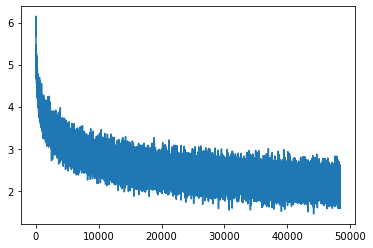

In [6]:
plt.plot(np.arange(len(losses)), losses)

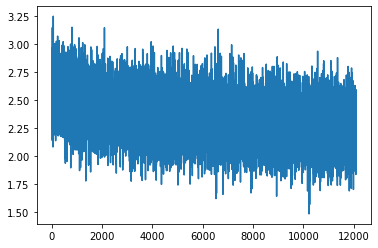

In [10]:
plt.plot(np.arange(len(losses)), losses)

In [5]:
seq_data, labels, token_weights = get_maksed_tokens(
            data, 
            cardinality
        )

column_indices.shape (5000, 8)


In [16]:
xformer_obj.encoder_obj

Encoder(
  (field_embedding): ModuleList(
    (0): Embedding(532, 16)
    (1): Embedding(2386, 16)
    (2): Embedding(1547, 16)
    (3): Embedding(264, 16)
    (4): Embedding(61, 16)
    (5): Embedding(127, 16)
    (6): Embedding(85, 16)
    (7): Embedding(2159, 16)
  )
  (PE): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (cat_xformer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (linear1): Linear(in_features=16, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=16, bias=True)
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (numAttr_LN): LayerNorm((0,), eps=1e-05, elementwise_affine=True

In [6]:
seq_data[128*6:128*7]

array([[  95, 1455,  530, ...,    0,   16, 1617],
       [  26,    0,  727, ...,  108,   55,  342],
       [  87,   93,   77, ...,   65,   32,  265],
       ...,
       [ 279, 2368,    0, ...,   83,   41, 2010],
       [  65,    0,   76, ...,  121,   15, 1529],
       [ 276,    0, 1486, ...,  121,   35,  325]])

In [17]:
np.max(seq_data[:,4])

61

In [7]:
cardinality

[532, 2386, 1547, 264, 61, 127, 85, 2159]

In [ ]:
a = np.array([[-1,1,-1],[1,-2,0]])
np.where(a == -1, 0, a) 
